In [1]:
import gc

import tifffile
import os
from time import time
import psutil
import zarr
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import PIL.Image as Image
from tqdm import tqdm
from typing import Union
import scipy
import matplotlib.pyplot as plt
import sys
import gc

sys.path.append('../scripts')
from Scripts.utils import Timer, show_mem_use

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

C:\Users\gamer\.conda\envs\vesuvius\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\gamer\.conda\envs\vesuvius\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\gamer\.conda\envs\vesuvius\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


cuda


In [2]:
INPUT_FOLDER = "../data"
WORKING_FOLDER = "/kaggle/working/"
PREFIX = '../data/train/1/'
TEST_PREFIX = '../data/test'  # '/kaggle/input/vesuvius-challenge-ink-detection/test/'
MODEL_PATH = '../model_checkpoints/brett_dict.pt' # "/kaggle/input/vesuvius-model/brett_dict.pt"
BATCH_SIZE = 564
THRESHOLD = 0.55

BUFFER = 30  # Buffer size in x and y direction
Z_START = 27 # First slice in the z direction to use
Z_DIM = 10   # Number of slices in the z direction
Z_SLICE = slice(Z_START, Z_START + Z_DIM, None)

In [3]:
show_mem_use()
with Timer():
    tif_folder = os.path.join(INPUT_FOLDER, "train", "2", "surface_volume", "*.tif")
    frag2_store = tifffile.imread(tif_folder, aszarr=True)
    frag2_stack = zarr.open(frag2_store, mode="r")
show_mem_use()
print(type(frag2_stack))
print(frag2_stack)
print(frag2_stack.shape)

338.88 MB used
Elapsed time: 2.8026 seconds
340.07 MB used
<class 'zarr.core.Array'>
<zarr.core.Array (65, 14830, 9506) uint16 read-only>
(65, 14830, 9506)


You see that loading the whole .tif stack only took a small amount of time and used only a couple
hundred megabytes of RAM.
 The z-levels are the first index and the x, y coordinates are the other indices.

Now we can access any bit of data we want without using an enormous amount of memory:

339.73 MB used
<class 'numpy.ndarray'>
Elapsed time: 2.7240 seconds
904.34 MB used


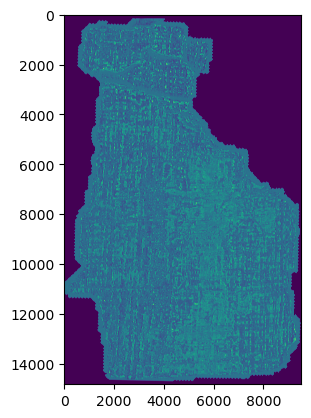

In [4]:
show_mem_use()
with Timer():
    frag_slice = frag2_stack[35,:,:]
    print(type(frag_slice))
plt.imshow(frag_slice)
show_mem_use()

910.91 MB used
Elapsed time: 2.6820 seconds
869.22 MB used


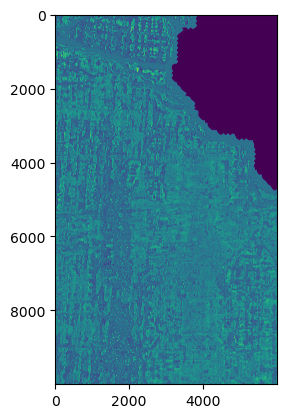

In [5]:
show_mem_use()
with Timer():
    frag_slice = frag2_stack[32,2000:12000,2000:8000]
plt.imshow(frag_slice)
show_mem_use()

We used 500 MB or so to load that single z-slice in and take a look at it, but as soon as we used that same variable to hold a different slice, we did not use additional memory for the new slice - the old one got deallocated.

You can use the zarr array just like a numpy array for most purposes, except that the data's held on disk and loaded into RAM when you slice.

# Attempt to combine this logic with Bretts other Torch Datasets
Does this just work by switching out the frag1_store/frag1_stack for his old fragzarr object?

In [9]:
mask = np.array(Image.open(PREFIX + "mask.png").convert('1'))
label = torch.from_numpy(np.array(Image.open(PREFIX + "inklabels.png"))).gt(0).float().to(DEVICE)

tif_folder = os.path.join(INPUT_FOLDER, "train", "1", "surface_volume", "*.tif")
frag1_store = tifffile.imread(tif_folder, aszarr=True)
frag1_stack = zarr.open(frag1_store, mode="r")

In [10]:
type(frag1_stack)

zarr.core.Array

In [11]:
frag1_stack.shape

(65, 8181, 6330)

In [15]:
frag1_stack[32,2000:12000,2000:8000].shape

(6181, 4330)

In [14]:
frag1_stack[32,2000:12000,2000:8000]  # [:,:,Z_START:Z_START+Z_DIM,0].astype(np.float32)

array([[32351, 32498, 32449, ...,     0,     0,     0],
       [30972, 29547, 30098, ...,     0,     0,     0],
       [28721, 27970, 27644, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0]], dtype=uint16)

In [19]:
frag1_stack[Z_START:Z_START+Z_DIM,:,:].shape

(10, 8181, 6330)

In [21]:
image_stack = torch.from_numpy(
    # N.B. the raw values are uint16, we need to cast to float and rescale to (0,1)
    frag1_stack[Z_START:Z_START+Z_DIM, :, :].astype(np.float32) / np.iinfo(np.uint16).max
    # fragzarr[:,:,Z_START:Z_START+Z_DIM,0].astype(np.float32) / np.iinfo(np.uint16).max
).to(DEVICE)

In [22]:
image_stack.shape

torch.Size([10, 8181, 6330])

In [23]:
with Timer():
    print("Generating pixel lists...")
    pixels_list = set()
    for pixel in zip(*np.where(mask)):
        if pixel[1] < BUFFER or pixel[1] >= mask.shape[1]-BUFFER or pixel[0] < BUFFER or pixel[0] >= mask.shape[0]-BUFFER:
            continue # Too close to the edge of the image
        pixels_list.add(pixel)
    pixels_list = list(pixels_list)

Generating pixel lists...
Elapsed time: 25.0168 seconds


In [31]:
class SubvolumeDataset(data.Dataset):
    # def __init__(self, image_stack: Tensor, label: Tensor, pixels: List):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        inklabel = self.label[y, x].view(1)
        return subvolume, inklabel

In [3]:
model = nn.Sequential(
    nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
    nn.MaxPool3d(kernel_size=2, stride=2),
    nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.MaxPool3d(kernel_size=2, stride=2),
    nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.MaxPool3d(kernel_size=2, stride=2),

    #Flattens dimensions 1+ into a single dimension, so it is a dim=2 matrix afterwards
    nn.Flatten(start_dim=1),
    nn.LazyLinear(out_features=128),
    nn.ReLU(),
    nn.LazyLinear(out_features=1),

    # Convert from (-inf, inf) to (0, 1) probability with a sigmoid
    nn.Sigmoid()
).to(DEVICE)

C:\Users\gamer\.conda\envs\vesuvius\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [34]:
print("Training on fragment 1...")
TRAINING_STEPS = 30000
LEARNING_RATE = 0.03
train_dataset = SubvolumeDataset(image_stack, label, pixels_list)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_STEPS)
model.train()
running_loss = 0.0

for i, (subvolumes, inklabels) in tqdm(enumerate(train_loader), total=TRAINING_STEPS):
    if i >= TRAINING_STEPS:
        break
    optimizer.zero_grad()
    # print(subvolumes.shape)
    outputs = model(subvolumes.to(DEVICE))
    loss = criterion(outputs, inklabels.to(DEVICE))
    loss.backward()
    optimizer.step()
    scheduler.step()
    running_loss += loss.item()
    if i % 3000 == 3000-1:
        print("Loss:", running_loss / 3000)
        running_loss = 0.0

  0%|          | 0/30000 [00:00<?, ?it/s]

Training on fragment 1...


 10%|█         | 3009/30000 [00:45<06:39, 67.59it/s]

Loss: 0.45031757721304894


 20%|██        | 6012/30000 [01:30<05:56, 67.21it/s]

Loss: 0.42006130464871727


 30%|███       | 9008/30000 [02:14<05:10, 67.56it/s]

Loss: 0.406583330390354


 40%|████      | 12011/30000 [02:59<04:27, 67.19it/s]

Loss: 0.3947377777347962


 50%|█████     | 15007/30000 [03:43<03:42, 67.44it/s]

Loss: 0.3869892700687051


 60%|██████    | 18010/30000 [04:27<02:57, 67.69it/s]

Loss: 0.37436820596208176


 70%|███████   | 21013/30000 [05:12<02:12, 67.76it/s]

Loss: 0.36380515950918196


 80%|████████  | 24009/30000 [05:57<01:29, 66.77it/s]

Loss: 0.34145346501966317


 90%|█████████ | 27012/30000 [06:42<00:44, 67.05it/s]

Loss: 0.30820906047771374


100%|██████████| 30000/30000 [07:27<00:00, 67.10it/s]

Loss: 0.27736985398456454


Add Some output training data

100%|██████████| 910529/910529 [58:11<00:00, 260.76it/s]


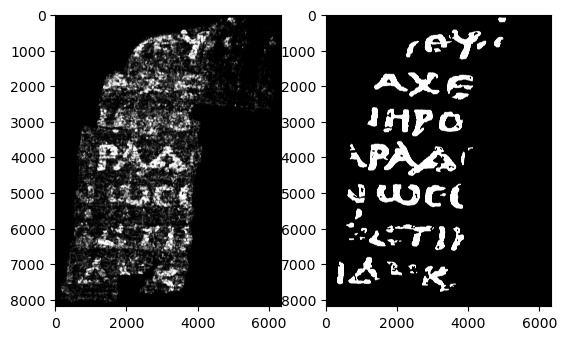

In [35]:
eval_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
output = torch.zeros_like(label).float()
model.eval()
with torch.no_grad():
    for i, (subvolumes, _) in enumerate(tqdm(eval_loader)):
        for j, value in enumerate(model(subvolumes.to(DEVICE))):
            output[pixels_list[i*BATCH_SIZE+j]] = value

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

In [36]:
np.save("/kaggle/working/frag1_results.array", output.cpu().numpy())

In [4]:
def dice_coef(preds, targets, beta=0.5, smooth=1e-5):
    preds = preds.view(-1).float()
    targets = targets.view(-1).float()

    y_true_count = targets.sum()
    ctp = preds[targets == 1].sum()
    cfp = preds[targets == 0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)
    return dice

Brett's Threshold stuff

In [38]:
thresholds = np.linspace(0.2, 0.9, 25)
scores = np.zeros_like(thresholds)
for i, t in enumerate(tqdm(thresholds)):
    scores[i] = dice_coef(output > t, label)

100%|██████████| 25/25 [00:00<00:00, 49.07it/s]


0.55 0.7073501348495483


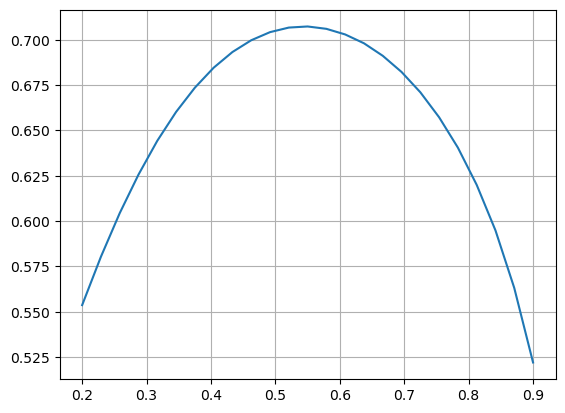

In [39]:
plt.figure()
plt.grid()
plt.plot(thresholds, scores)
idx = np.argmax(scores)
print(thresholds[idx], scores[idx])

Look at maximum score in the above graph. Use that point for your threshold.

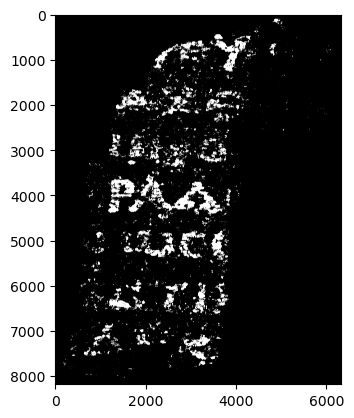

In [46]:
plt.imshow(output.cpu() > 0.55, cmap='gray')

In [47]:
torch.save(model.state_dict(), f"../model_checkpoints/brett_dict.pt")

In [48]:
torch.save(model, f"../model_checkpoints/brett.pt")

# Do inference with brett dataset and this ^ saved model.

In [55]:
del image_stack, label
gc.collect()
torch.cuda.empty_cache()

In [4]:
model.load_state_dict(torch.load("../model_checkpoints/brett_dict.pt"))
model.to(DEVICE)

Sequential(
  (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): LazyLinear(in_features=0, out_features=128, bias=True)
  (8): ReLU()
  (9): LazyLinear(in_features=0, out_features=1, bias=True)
  (10): Sigmoid()
)

In [ ]:
class TestSubvolumeDataset(data.Dataset):
    # def __init__(self, image_stack: Tensor, label: Tensor, pixels: List):
    def __init__(self, image_stack, pixels):
        self.image_stack = image_stack
        self.pixels = pixels

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        # inklabel = self.label[y, x].view(1)
        return subvolume  #, inklabel

In [7]:
# Load test folder as Zarr
test_mask = np.array(Image.open(TEST_PREFIX + "/a/mask.png").convert('1'))
test_tif_folder = os.path.join(INPUT_FOLDER, "test", "a", "surface_volume", "*.tif")
frag_a_store = tifffile.imread(test_tif_folder, aszarr=True)
frag_a_stack = zarr.open(frag_a_store, mode="r")

In [8]:
# N.B. the raw values are uint16, we need to cast to float and rescale to (0,1)
test_image_stack = torch.from_numpy(frag_a_stack[Z_START:Z_START + Z_DIM, :, :].astype(np.float32) / np.iinfo(np.uint16).max) #.to(DEVICE)
test_image_stack.shape

torch.Size([10, 2727, 6330])

In [9]:
with Timer():
    print("Generating test pixel lists...")
    pixels_list = set()
    for pixel in zip(*np.where(test_mask)):
        if pixel[1] < BUFFER or pixel[1] >= test_mask.shape[1]-BUFFER or pixel[0] < BUFFER or pixel[0] >= test_mask.shape[0]-BUFFER:
            continue # Too close to the edge of the image
        pixels_list.add(pixel)
    pixels_list = list(pixels_list)

Generating test pixel lists...
Elapsed time: 9.1630 seconds


In [11]:
test_dataset = TestSubvolumeDataset(test_image_stack, pixels_list)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## Show the Output of fragment 'A'

In [13]:
# Frag a took 2723 seconds or 45 mins with 0 num_workers
with Timer("Doing frag a inference"):
    output = torch.zeros_like(torch.from_numpy(test_mask)).float()
    model.eval()
    with torch.no_grad():
        for i, (subvolumes) in enumerate(tqdm(test_loader, total=len(test_loader))):
            for j, value in enumerate(model(subvolumes.to(DEVICE))):
                output[pixels_list[i*BATCH_SIZE+j]] = value

100%|██████████| 18988/18988 [45:23<00:00,  6.97it/s]

Doing frag a inference: 2723.4540 seconds


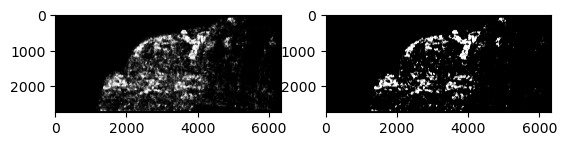

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.cpu(), cmap='gray')
ax2.imshow(output.cpu() > 0.55, cmap='gray')
plt.show()

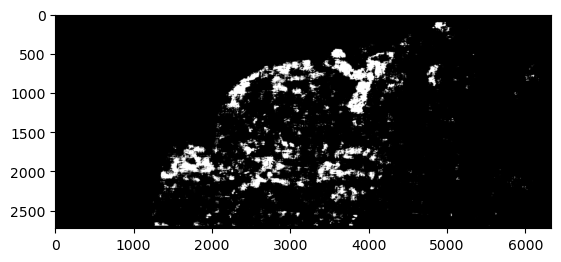

In [15]:
plt.imshow(output.cpu() > 0.55, cmap='gray')

In [25]:
def rle(output):
    """
    Kaggle expects a "Runlength encoding" for the submission.
    :param output: torch.Tensor
    :return:
    """
    flat_img = np.where(output.flatten().cpu() > THRESHOLD, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_fast(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.flatten()
    pixels = (pixels >= THRESHOLD) #.astype(int)

    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [26]:
output.shape

torch.Size([2727, 6330])

In [29]:
%%timeit
rle(output)

3.26 s ± 42.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%timeit
rle_fast(output)

114 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
